# Regularyzacja w modelu regresji - porównanie regresji grzbietowej i regresji Lasso

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

**Regularyzacja grzbietowa** i **Lasso** są technikami, które są wykorzystywane do budowania **oszczędnych modeli**, w rozumieniu obecności zbyt dużej liczby predyktorów.
Przez dużą liczbę predyktorów rozumiemy:

- *duża liczba predyktorów* to taka, która prowadzi do **przeuczenia modelu** (ang. *overfitting*) -- nawet tak niewielka liczba jak 10 zmiennych może prowadzić do przeuczenia,
    
- *duża liczba predyktorów* to taka, która może prowadzić do problemów z **wydajnością obliczeniową** -- przy obecnych możliwościach komputerów, taka sytuacja może mieć miejsce przy występowaniu milionów lub miliardów cech.

Techniki regularyzacyjne działają poprzez
- karanie wielkości współczynników cech,
- minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami.

## Dlaczego karamy za wielkość współczynników?

Rozważmy następujący przykład celem zrozumienia wpływu złożoności modelu na wielkość współczynników.

W tym celu dopasujmy krzywą regresji do krzywej sinusoidalnej (od 0° do 360°) z dodanym szumem.

In [2]:
np.random.seed(123)

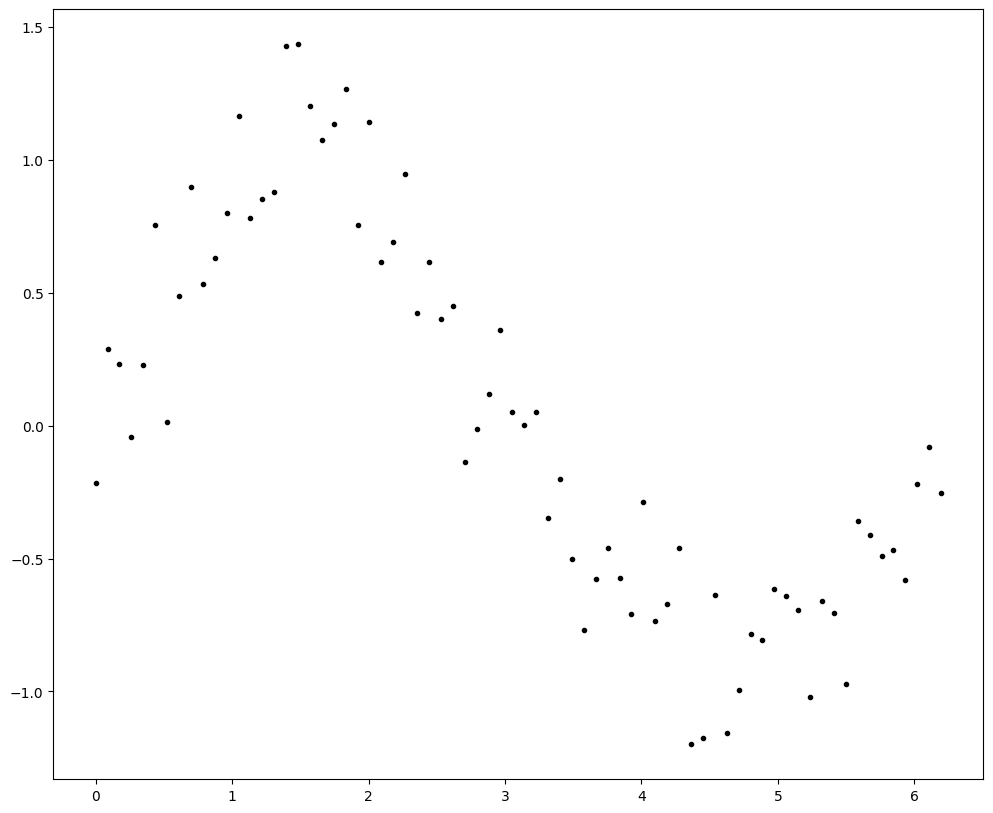

In [3]:
x = np.array([i * np.pi/180 for i in range(0, 360, 5)])
X = pd.DataFrame(x)
y = np.sin(x) + np.random.normal(0, .2, len(x))
plt.plot(x, y, '.', color = 'black')

In [4]:
#lambda to taka prosta funkcja, bierze dowolną liczbę argumentów, ale może mieć w sobie tylko jedno wyrażenie
rss_fun  = lambda y, y_pred: sum((y_pred-y)**2)

In [5]:
#funkcja tworzy model regresji wielomianowej bez regularyzacji, dopasowuje model do danych i rysuje wykres dla dopasowanych wartości w modelu
#zwraca RSS, wyraz wolny i resztę współczynników
def linear_regression(X, y, power, models_to_plot):
    reg = make_pipeline(PolynomialFeatures(power),
                        StandardScaler(),
                        LinearRegression())
    reg.fit(X, y)
    y_pred = reg.predict(X)

    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(x, y_pred)
        plt.plot(x, y, '.')
        plt.title('Plot for power: %d' % power)

    ret = [rss_fun(y, y_pred)]
    ret.extend([reg.named_steps['linearregression'].intercept_])
    ret.extend(reg.named_steps['linearregression'].coef_[1:])
    return ret

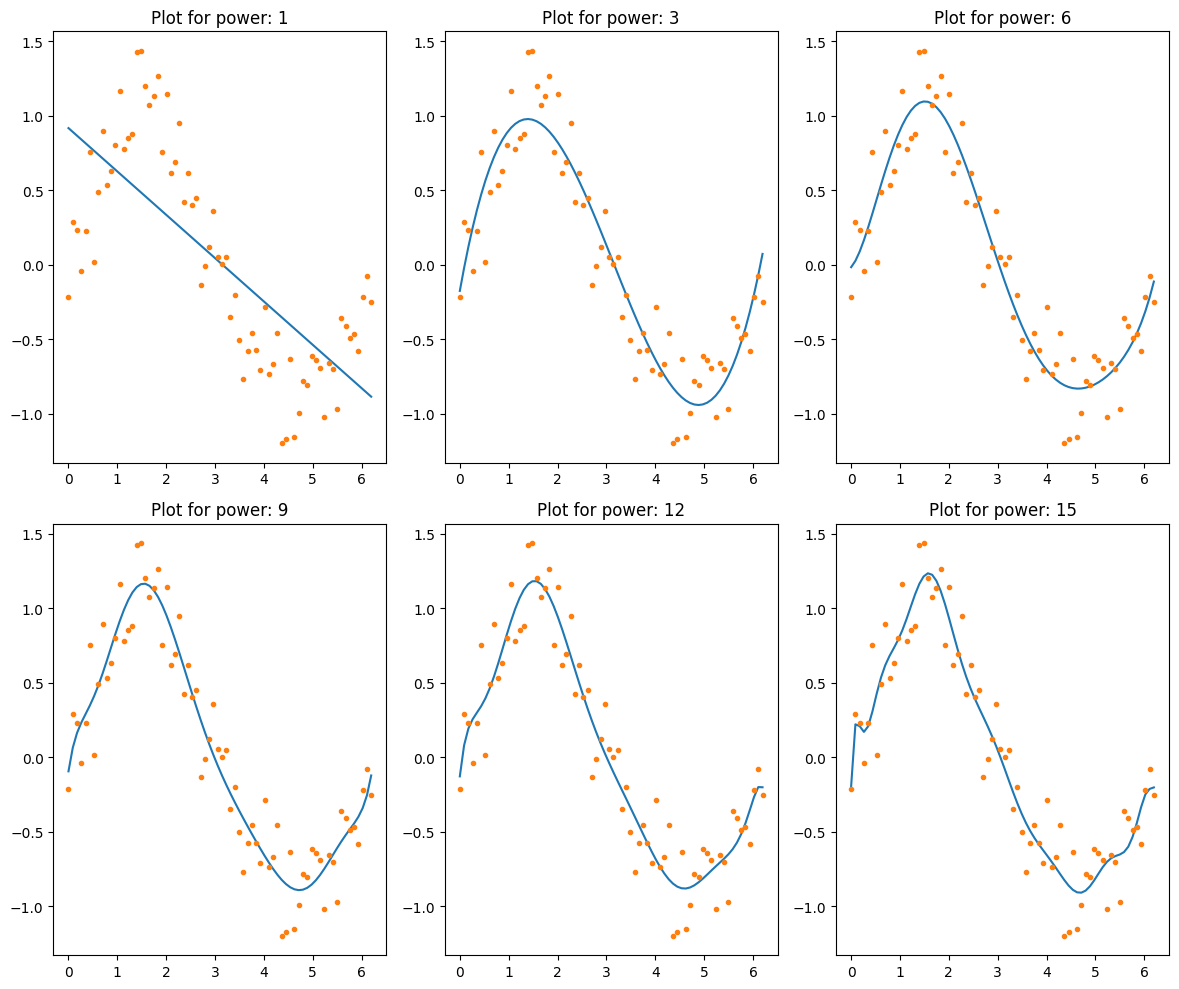

In [6]:
#rysujemy wykres regresji wielomianowej bez regularyzacji, dla różnych potęg
col = ['RSS', 'Intercept'] + ['coef_x_%d' % i for i in range(1, 16)]
ind = ['model_pow_%d' % i for i in range(1, 16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1:231, 3:232, 6:233, 9:234, 12:235, 15:236}

for i in range(1, 16):
    coef_matrix_simple.iloc[i-1, 0:i+2] = linear_regression(X, y, power=i, models_to_plot=models_to_plot)

In [7]:
#wypisujemy współczynniki dla kolejnych modeli regresji wielomianowej bez regularyzacji
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,RSS,Intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,17,0.015,-0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,17,0.015,-0.41,-0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,3.9,0.015,3.3,-9.8,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,3.6,0.015,4.2,-14,13,-3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,3.4,0.015,2.6,-1.7,-19,31,-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,3.2,0.015,0.65,19,-1e+02,1.8e+02,-1.3e+02,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,3.1,0.015,-0.48,36,-1.9e+02,4.1e+02,-4.6e+02,2.6e+02,-62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,3.1,0.015,0.73,12,-20,-2e+02,7.7e+02,-1.1e+03,7.4e+02,-1.9e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,3,0.015,4.1,-72,7.6e+02,-3.9e+03,1.1e+04,-1.7e+04,1.6e+04,-7.8e+03,1.6e+03,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,3,0.015,6.6,-1.5e+02,1.7e+03,-9.2e+03,2.9e+04,-5.6e+04,6.8e+04,-5e+04,2.1e+04,-3.7e+03,NaN,NaN,NaN,NaN,NaN


**Podsumowanie**:

- wielkość współczynników regresji rośnie eksponencjalnie wraz ze wzrostem złożoności modelu,
- wielkość współczynnika regresji wpływa na istotność zmiennej odpowiadającej temu współczynnikowi w oszacowaniu wielkość zmiennej odpowiedzi, ale gdy wielkość współczynnik jest zbyt duża, algorytm modeluje skomplikowane relacje w celu oszacowania wyników, co często kończy się zbytnim dopasowaniem do danych,

# Regularyzacja grzbietowa (ang. *rigde regression*)

Metoda najmniejszych kwadratów z regularyzacją $l2$, minimalizuje **funkcję kryterialną**:

$$||y - Xb||^2_2 + \alpha \cdot ||b||^2_2,$$

gdzie dla dowolnego wektora $n$-wymiarowego $a = (a_1, a_2, \ldots, a_n)$ zachodzi: $||a||_2 = \sqrt{\sum_{i=1}^n a_i^2}$.

$\alpha$ - siła regularyzacja, $\alpha > 0$

* gdy $\alpha = 0$ -- problem uprasza się do zwykłej regresji
* gdy $\alpha = +\infty$ -- współczynnik są równe zeru

## Zadanie 1
Napisz funkcję, która dla dowolnego zbioru ($X$ i $y$) oraz stopnia wielomianu dopasuje model regresji wielomianowej z regularyzacją Ridge z danym parametrem $\alpha$. Ponadto, funkcja narysuje wykres rozproszenia i dopasowaną funkcję regresji dla $k$ danych wartości parametru $\alpha$ przy ustalonym stopniu wielomianu (parametr
`models_to_plot`).

Następnie wyznacz ramkę danych `coef_matrix_ridge` dla ustalonego stopnia wielomianu (np. 15), której wiersze dla ustalonej będą zawierały: wartość RSS oraz kolejne wartości współczynników regresji dla różnych parametrów $\alpha$, np. lista `alpha_ridge`.

Sprawdź jak zmieniają się wartości współczynników regresji z regularyzacją grzbietową wraz ze zmianą parametru $\alpha$.

In [8]:
#analogiczna funkcja co wcześniej, ale teraz dla Ridge
from sklearn.linear_model import Ridge

def ridge_regression(X, y, alpha, power, models_to_plot={}):
    ridgereg = make_pipeline(PolynomialFeatures(power),
                        StandardScaler(),
                        Ridge(alpha = alpha))
    ridgereg.fit(X, y)
    y_pred = ridgereg.predict(X)

    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(x, y_pred)
        plt.plot(x, y, '.')
        plt.title('Plot for alpha: %.3g' % alpha)

    ret = [rss_fun(y, y_pred)]
    ret.extend([ridgereg.named_steps['ridge'].intercept_])
    ret.extend(ridgereg.named_steps['ridge'].coef_[1:])
    return ret

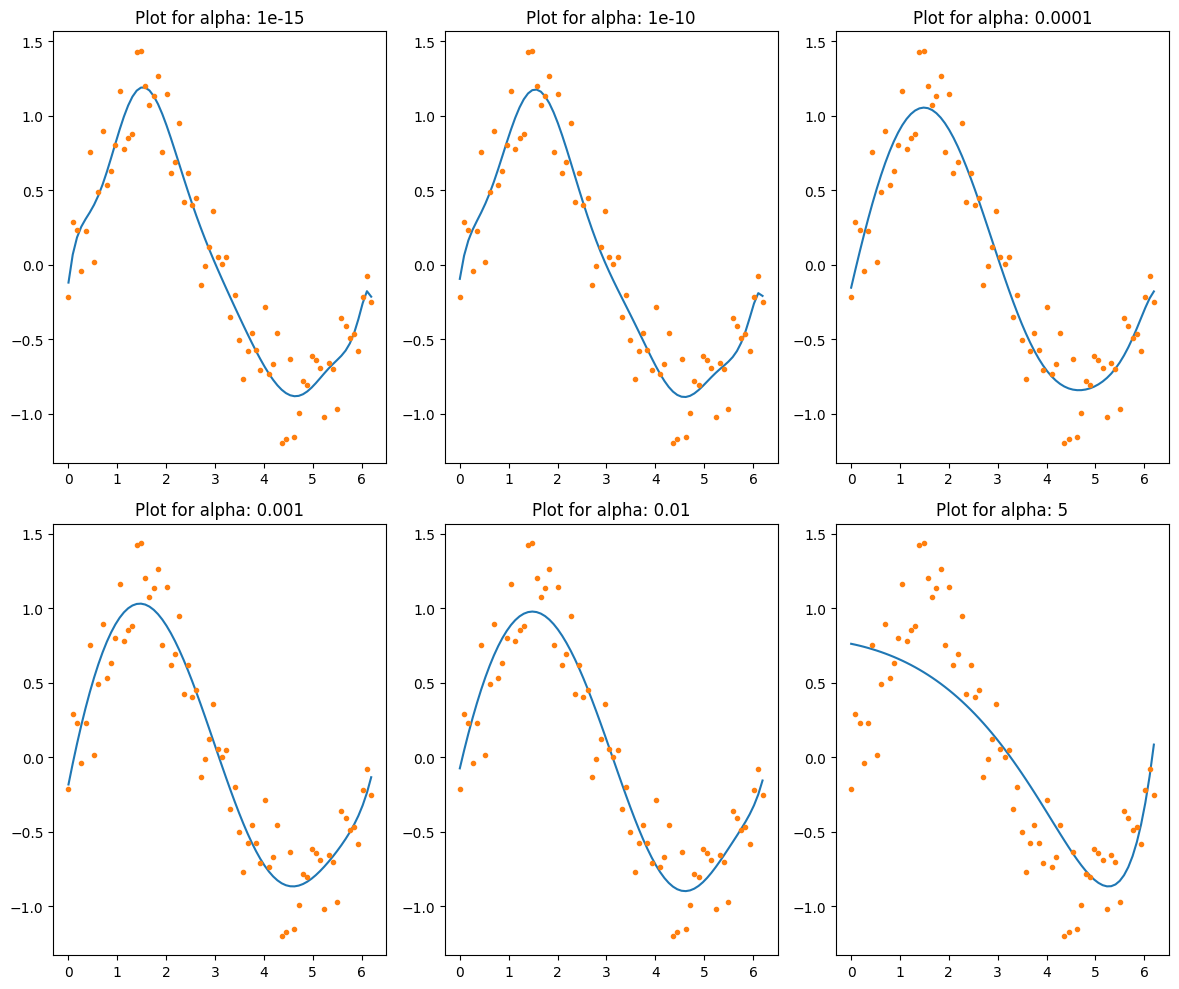

In [9]:
#rysujemy wykres regresji wielomianowej z regularyzacją ridge,dla różnych alph dla potęgi 15
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

col = ['RSS','Intercept'] + ['coef_x_%d'%i for i in range(1, 16)]
ind = ['alpha_%.2g' % alpha_ridge[i] for i in range(0, len(alpha_ridge))]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}


power = 15
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(X, y, alpha_ridge[i], power, models_to_plot)

In [10]:
# i współczynniki dla różnych alph
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,RSS,Intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,3,0.015,4.9,-84,7.2e+02,-2.5e+03,3.4e+03,-1e+04,8.6e+04,-3.3e+05,6.2e+05,-5.4e+05,-7.3e+04,6.7e+05,-6.7e+05,3.1e+05,-5.6e+04
alpha_1e-10,3,0.015,4,-64,6.1e+02,-2.7e+03,5.3e+03,-3.8e+03,-1.8e+03,2.5e+03,1.8e+03,-1e+03,-1.7e+03,-1.5e+02,1.1e+03,3.7e+02,-4.4e+02
alpha_1e-08,3,0.015,0.89,5.8,38,-3.9e+02,8.5e+02,-3.7e+02,-6.2e+02,1.5e+02,5.9e+02,2.3e+02,-3.7e+02,-5e+02,51,6.3e+02,-3e+02
alpha_0.0001,3.3,0.015,2.6,-2.2,-13,8.5,11,2.3,-4.7,-6.5,-4.2,-0.48,2.7,4.1,3.3,0.51,-4
alpha_0.001,3.4,0.015,3,-6.2,-2.6,3.4,3.9,1.7,-0.62,-1.8,-1.7,-1,-0.067,0.69,0.96,0.58,-0.54
alpha_0.01,3.5,0.015,2.6,-5.3,-1.5,1.5,2.2,1.6,0.67,-0.18,-0.72,-0.93,-0.86,-0.58,-0.16,0.34,0.87
alpha_1,8.1,0.015,0.29,-0.87,-0.65,-0.24,0.064,0.24,0.3,0.31,0.26,0.19,0.11,0.027,-0.061,-0.15,-0.23
alpha_5,11,0.015,-0.12,-0.39,-0.29,-0.15,-0.034,0.041,0.084,0.1,0.11,0.096,0.079,0.058,0.034,0.0092,-0.016
alpha_10,12,0.015,-0.18,-0.3,-0.22,-0.13,-0.048,0.0054,0.04,0.059,0.068,0.069,0.066,0.059,0.05,0.04,0.029
alpha_20,12,0.015,-0.19,-0.23,-0.17,-0.11,-0.054,-0.014,0.013,0.032,0.043,0.05,0.053,0.054,0.053,0.051,0.048


**Podsumowanie**:

- wielkość RSS (suma kwadratów błędów) rośnie wraz ze wzrostem wartości $\alpha$, wraz z redukcją złożoności modelu,
- $\alpha = 1e-15$ daje istotną redukcję wielkości współczynników regresji,
- wyższe wartości $\alpha$ prowadzą do niedouczenia modelu (gwałtowny wzrost RSS dla $\alpha > 1$.
- wiele współczynników jest bardzo małych, ale nie równych zeru.

# Regularyzacja Lasso (ang. *Lasso regression*)

LASSO - Least Absolute Shrinkage and Selection Operator

Metoda najmniejszych kwadratów z regularyzacją $l1$, minimalizuje **funkcję kryterialną**:

$$||y - Xb||^2_2 + \alpha \cdot ||b||_1,$$

gdzie dla dowolnego wektora $n$-wymiarowego $a = (a_1, a_2, \ldots, a_n)$ zachodzi: $||a||_1 = \sum_{i=1}^n |a_i|$.

## Zadanie 2
Napisz funkcję, która dla dowolnego zbioru ($X$ i $y$) oraz stopnia wielomianu dopasuje model regresji wielomianowej z regularyzacją Lasso z danym parametrem $\alpha$. Ponadto, funkcja narysuje wykres rozproszenia i dopasowaną funkcję regresji dla $k$ danych wartości parametru $\alpha$ przy ustalonym stopniu wielomianu (parametr
`models_to_plot`).

Następnie wyznacz ramkę danych `coef_matrix_ridge` dla ustalonego stopnia wielomianu (np. 15), której wiersze dla ustalonej będą zawierały: wartość RSS oraz kolejne wartości współczynników regresji dla różnych parametrów $\alpha$, np. lista `alpha_ridge`.

Sprawdź jak zmieniają się wartości współczynników regresji z regularyzacją Lasso wraz ze zmianą parametru $\alpha$.

In [17]:
#definiujemy funkcję, która dopasowuje model lasso dla regresji wielomianowej i tworzy wykresy dla pewnych alph, zwraca współczynniki i RSS
#
from sklearn.linear_model import Lasso

def lasso_regression(X, y, alpha, power, models_to_plot={}):
    lassoreg = make_pipeline(PolynomialFeatures(power),
                        StandardScaler(),
                        Lasso(alpha = alpha,max_iter = 100000))
    lassoreg.fit(X, y)
    y_pred = lassoreg.predict(X)

    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(x, y_pred)
        plt.plot(x, y, '.')
        plt.title('Plot for alpha: %.3g' % alpha)

    ret = [rss_fun(y, y_pred)]
    ret.extend([lassoreg.named_steps['lasso'].intercept_])
    ret.extend(lassoreg.named_steps['lasso'].coef_[1:])
    return ret

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e+00, tolerance: 3.676e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e+00, tolerance: 3.676e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e+00, tolerance: 3.676e

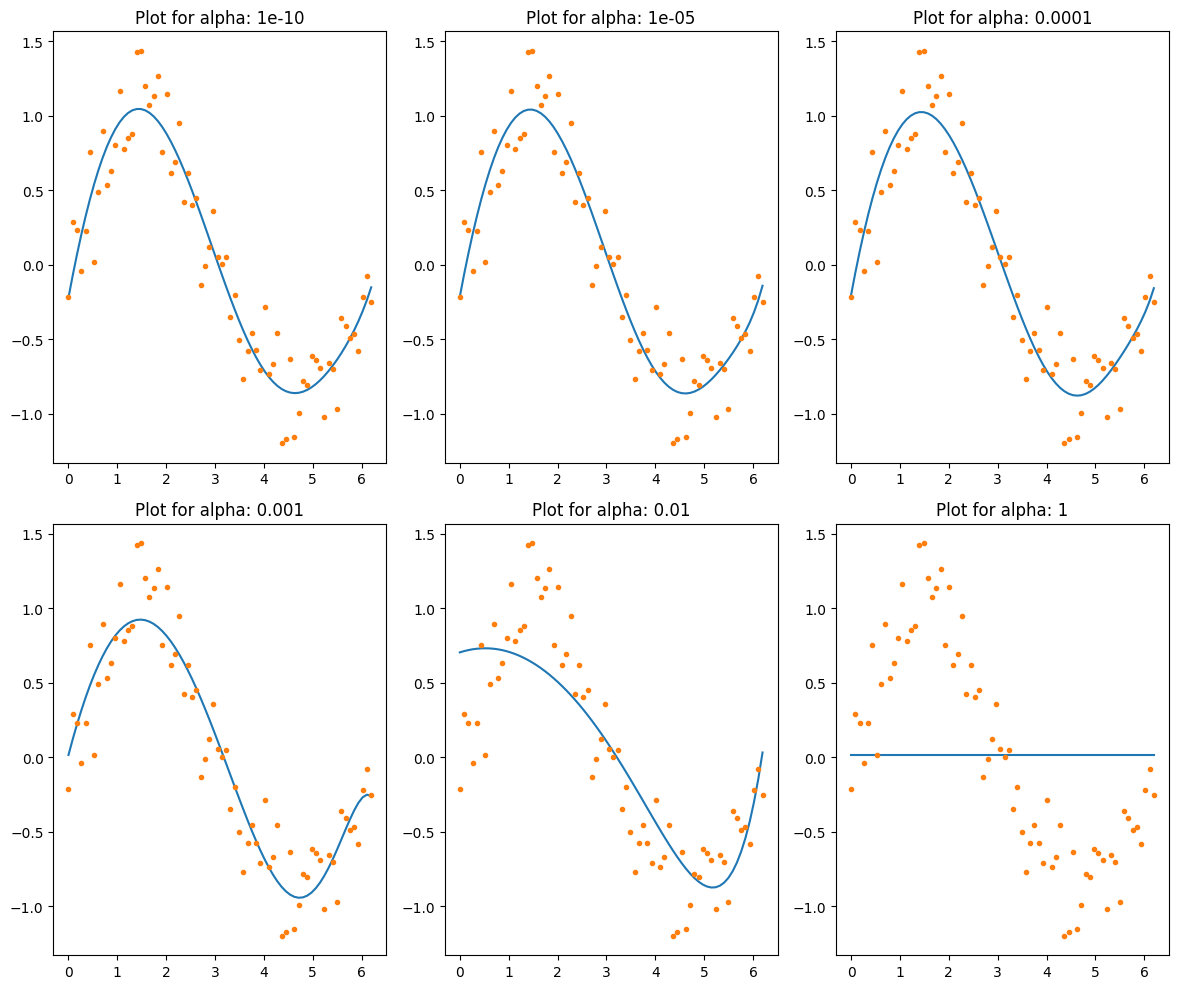

In [18]:
#rysujemy wykresy, dla różnych alph
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

col = ['RSS','Intercept'] + ['coef_x_%d' % i for i in range(1, 16)]
ind = ['alpha_%.2g' % alpha_lasso[i] for i in range(0, 10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
power
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(X, y, alpha_lasso[i], power, models_to_plot)

In [19]:
#wypisujemy wpółczynniki i RSS, tutaj w przeciwieństwie do ridge niektóre współczynniki się zerują (im większe alpha tym więcej osób się zeruje)
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,RSS,Intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,3.4,0.015,3.2,-6.6,-4.3,7.6,3.5,-0.69,-2,-1.6,-0.72,0.048,0.49,0.59,0.43,0.084,-0.38
alpha_1e-10,3.4,0.015,3.2,-6.6,-4.3,7.6,3.5,-0.69,-2,-1.6,-0.72,0.048,0.49,0.59,0.43,0.084,-0.38
alpha_1e-08,3.4,0.015,3.2,-6.6,-4.3,7.6,3.5,-0.69,-2,-1.6,-0.72,0.048,0.49,0.59,0.43,0.083,-0.38
alpha_1e-05,3.4,0.015,3.2,-6.7,-3.4,6.4,3.1,-0,-1.5,-1.6,-0.55,-0,0.0037,0.33,0.34,0.072,-0
alpha_0.0001,3.4,0.015,3.2,-7.6,-0,3.5,2,0,-0,-0,-1.7,-0.11,-0,-0,0,0,0.41
alpha_0.001,3.9,0.015,2.3,-5.1,0,0,3,0,0,-0,-0,-0,-0,-0.56,-0,-0,-0
alpha_0.01,9.2,0.015,0.19,-1.2,-0,-0,0,0,0,0.59,0,0,0,0,0,0,0
alpha_1,37,0.015,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,37,0.015,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,37,0.015,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


**Podsumowanie**:

- wielkość RSS (suma kwadratów błędów) rośnie wraz ze wzrostem wartości 𝛼, wraz z redukcją złożoności modelu,
- dla tych samym wartości $\alpha$, wielkość współczynników regresji z regularyzacją Lasso jest mniejsza niż wartości odpowiadających współczynników w regresji z regularyzacją grzbietową,
- dla tych samych wartości $\alpha$ regresji z regularyzacją Lasso ma wyższe RSS w porównaniu do regresji z regularyzacją grzbietową (gorsze dopasowanie modelu),
- wiele współczynników jest zerowa (nawet dla niewielkich wielkości $\alpha$).

## Porównanie regularyzacji grzbietowej z regularyzacją Lasso

### Ridge
- zawiera wszystkie (lub żadne) cechy w modelu, główną zaletą tej regularyzacji jest **ściągniecie współczynników** (ang. **shrinkage coefficient**),
- regresji grzbietowej używa się głowniej do **uniknięcia przeuczenia** modelu, ale z racji, że zawiera wszystkie zmienne z modelu nie jest użyteczny w przypadku wielowymiarowych danych (gdy liczbę predyktorów szacuje się milionach/miliardach -- zbyt duża złożoność obliczeniowa),
- zasadniczo działa dobrze nawet w obecności silnie **skorelowanych** cech -- uwzględnia wszystkie skorelowane zmienne w modelu, ale wielkość współczynników zależy od wielkości korelacji.


### Lasso
- regularyzacja Lasso poza **ściągniecie współczynników**, dokonuje również selekcji zmiennych
- regularyzacje Lasso często wykorzystuje się do **selekcji zmiennych** w przypadku do liczba cech jest rzędu milionów/miliardów
- wybiera dowolną cechę spośród cech silnie skorelowanych, współczynniki pozostałych cechy skorelowanych z wybraną zmienną redukuje do zera, ale wybrana zmienna zmienia się losowo wraz ze zmianą parametrów modelu -- podejście te działa gorzej niż regularyzacja grzbietowa